In [1]:
import seaborn as sns
import pandas as pd
from pathlib import Path
from utils import *
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import fastai
from fastai.vision import *

In [63]:
DATAPATH = Path.cwd()/'Univariate_arff'

In [64]:
list(DATAPATH.iterdir())

[PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/PowerCons'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/PhalangesOutlinesCorrect'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/Herring'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/ElectricDevices'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/CBF'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/Plane'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/DataSummaryExpanded_v03.xlsx'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/MiddlePhalanxTW'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/ECG5000'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/CricketZ'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/WormsTwoClass'),
 PosixPath('/home/tc256760/Documents/Time

In [65]:
task = 'Adiac'
df_train, df_test = load_df(DATAPATH, task)
df_train, ts_train = cleanup(df_train)
df_test, ts_test = cleanup(df_test)

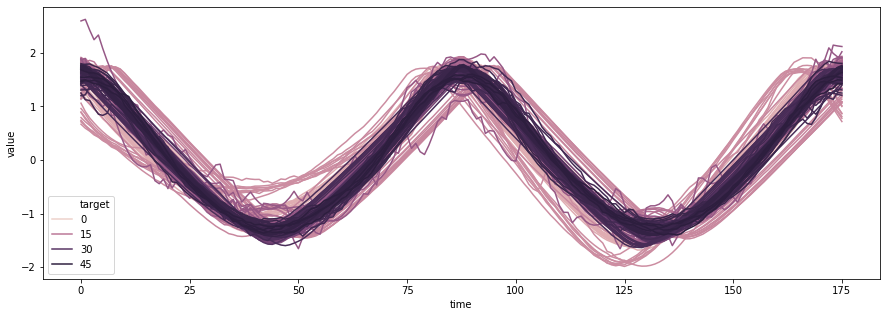

In [66]:
graph_ts(ts_train)

In [68]:
len(df_test)

391

# DL

In [6]:
def get_ds(df):
    return TensorDataset(torch.Tensor(df.values[:,:-1].astype('float')).unsqueeze(dim=1), 
                         torch.Tensor(df.values[:,-1].astype('int')).long())

In [7]:
num_classes = df_train.target.nunique(); num_classes

37

In [8]:
tr_ds, val_ds = get_ds(df_train), get_ds(df_test)

In [9]:
def create_databunch(tr_ds, val_ds):
    train_dl = DataLoader(tr_ds, batch_size=64, shuffle=True)
    valid_dl = DataLoader(val_ds, batch_size=64, shuffle=True)
    return DataBunch(train_dl, valid_dl)

In [10]:
db = create_databunch(tr_ds, val_ds)

Testing dims at input/output

In [11]:
tx, ty = next(iter(db.valid_dl))

In [12]:
tx.shape, ty.shape

(torch.Size([64, 1, 176]), torch.Size([64]))

## Convolutions

In [13]:
from resnet import create_resnet

In [14]:
model = create_resnet(1, num_classes, ks=9, conv_sizes=[64, 128, 256, 256]); model

Sequential(
  (0): Sequential(
    (0): Conv1d(1, 64, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): SequentialEx(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (1): ReLU(inplace=True)
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (1): ReLU(inplace=True)
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): MergeLayer()
    )
  )
  (2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [15]:
learn_res = fastai.basic_train.Learner(db, 
                                       model, 
                                       loss_func = CrossEntropyFlat(), 
                                       metrics=[error_rate],
                                       wd=1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


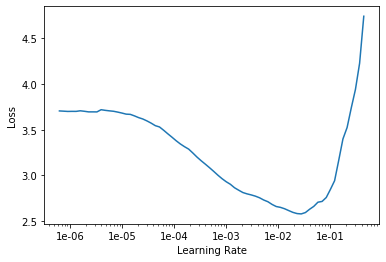

In [16]:
learn_res.lr_find(); learn_res.recorder.plot()

In [17]:
learn_res.fit_one_cycle(40, 5e-4)

epoch,train_loss,valid_loss,error_rate,time
0,3.482689,3.862900,0.961538,00:00
1,3.062952,3.773185,0.992308,00:00
2,2.749942,3.723776,0.946154,00:00
3,2.515209,3.464745,0.889744,00:00
4,2.311406,3.003469,0.756410,00:00
5,2.160355,2.473014,0.535897,00:00
6,2.026032,2.302877,0.571795,00:00
7,1.931490,1.891652,0.441026,00:00
8,1.835643,1.568685,0.392308,00:00
9,1.768915,1.676331,0.489744,00:00


In [19]:
p, t = learn_res.get_preds()

In [50]:
error_rate(p,t)

tensor(0.0641)

In [55]:
len(tr_ds)

390

In [27]:
pd.Series({'Adiac': 0.7974358797073364})

Adiac    0.797436
dtype: float64

In [21]:
def get_cm(p, t): return confusion_matrix(t, p.softmax(dim=1).argmax(1))

Confusion Matrix

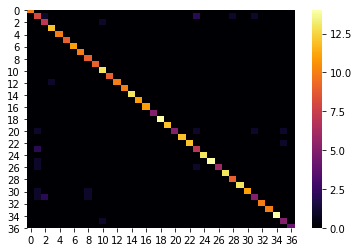

In [22]:
sns.heatmap(get_cm(p,t), cmap='inferno')